In [1]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import json
from pathlib import Path
from typing import Callable

import torch
from datasets import Dataset, DatasetDict, load_dataset
from numpy.typing import NDArray
from torch import Tensor, nn
from tqdm import tqdm
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
from ulid import ulid

from luminar.utils.training import LuminarTrainingConfig
from luminar.classifier import LuminarCNN
from luminar.utils import (
    ConvolutionalLayerSpec,
    compute_metrics,
    get_matched_datasets,
    get_pad_to_fixed_length_fn,
    save_model,
)

HF_TOKEN = (Path.home() / ".hf_token").read_text().strip()

### Encoder

In [3]:
# from luminar.encoder import LuminarEncoder


# encoder = LuminarEncoder()
# encoder.device = "cuda:0"

### Classifier

In [4]:
agent = "gpt_4o_mini"
other_agents = "gemma2_9b"
domain = "blog_authorship_corpus"

In [5]:
feature_len = 128
seed = 42

pad_to_fixed_length: Callable[[NDArray], NDArray] = get_pad_to_fixed_length_fn(
    feature_len
)

In [6]:
datset_config_name = f"{domain}-fulltext"
dataset_split_name = f"human+{agent}+{other_agents}"
dataset: Dataset = (
    load_dataset(
        "liberi-luminaris/PrismAI-encoded-gpt2",
        datset_config_name,
        split=dataset_split_name,
        token=HF_TOKEN,
    )  # type: ignore
    .rename_column("label", "labels")
    .filter(
        lambda features: len(features) > 0,
        input_columns=["features"],
        num_proc=8,
    )
    .with_format("numpy", columns=["features"])
    .map(
        lambda features: {"features": pad_to_fixed_length(features)},
        input_columns=["features"],
        desc="Trimming & Padding Features",
        num_proc=8,
    )
)
dataset

Trimming & Padding Features (num_proc=8):   0%|          | 0/37864 [00:00<?, ? examples/s]

Dataset({
    features: ['agent', 'id_sample', 'id_source', 'labels', 'length', 'features'],
    num_rows: 37864
})

In [7]:
datasets_matched, dataset_unmatched = get_matched_datasets(dataset, agent)
datasets_matched.set_format("torch", columns=["labels", "features"])
dataset_unmatched.set_format("torch", columns=["labels", "features"])

Filter:   0%|          | 0/37864 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37864 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37864 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37864 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37864 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37864 [00:00<?, ? examples/s]

In [10]:
train_batch_size = 32
steps_per_epoch = len(datasets_matched["train"]) // train_batch_size
eval_steps = steps_per_epoch // 5

run_ulid = ulid()
config = LuminarTrainingConfig(
    feature_len=feature_len,
    feature_dim=(feature_len, 13),
    feature_type="intermediate_likelihoods",
    feature_model="gpt2",
    feature_selection="first",
    agent=agent,
    domain=domain,
    other_agents=other_agents,
    datset_config_name=other_agents,
    dataset_split_name="+".join(("human", agent, *other_agents)),
    conv_layer_shapes=(
        ConvolutionalLayerSpec(32, 7),
        ConvolutionalLayerSpec(64, 5),
        ConvolutionalLayerSpec(32, 3),
    ),
    projection_dim=(512, 32),
    seed=seed,
    run_ulid=run_ulid,
)

In [11]:
training_args = TrainingArguments(
    output_dir="../logs/hf/" + run_ulid,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=1024,
    learning_rate=5e-4,
    num_train_epochs=10,
    # lr_scheduler_type="reduce_lr_on_plateau",
    # lr_scheduler_kwargs={
    #     "mode": "min",
    #     "factor": 0.5,
    #     "patience": 3,
    #     "threshold": 0.001,
    #     "threshold_mode": "rel",
    #     # "cooldown": 1,
    #     "min_lr": 1e-6,
    # },
    warmup_steps=steps_per_epoch,
    logging_steps=eval_steps,
    load_best_model_at_end=True,
    # metric_for_best_model="accuracy",
    # greater_is_better=True,
    eval_strategy="steps",
    eval_steps=eval_steps,
    eval_delay=steps_per_epoch,
    save_strategy="steps",
    save_steps=eval_steps,
    # torch_compile=True,
    # torch_compile_mode="reduce-overhead"
    seed=seed,
)

In [12]:
from collections import OrderedDict
import torch.nn.functional as F
from transformers.utils.generic import ModelOutput


class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1 = nn.LazyConv1d(c1, kernel_size=1)
        # Branch 2
        self.b2 = nn.Sequential(
            nn.LazyConv1d(c2[0], kernel_size=1),
            nn.LeakyReLU(),
            nn.LazyConv1d(c2[1], kernel_size=3, padding=1),
            nn.LeakyReLU(),
        )
        # Branch 3
        self.b3 = nn.Sequential(
            nn.LazyConv1d(c3[0], kernel_size=1),
            nn.LeakyReLU(),
            nn.LazyConv1d(c3[1], kernel_size=5, padding=2),
            nn.LeakyReLU(),
        )
        # Branch 4
        self.b4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.LazyConv1d(c4, kernel_size=1),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return torch.cat((self.b1(x), self.b2(x), self.b3(x), self.b4(x)), dim=1)


class AltLuminarCNN(nn.Module):
    def __init__(
        self,
        **kwargs,
    ):
        super().__init__()

        config = LuminarTrainingConfig(**kwargs)

        feature_len, feature_depth = config.feature_dim

        self.cnn = nn.Sequential(
            OrderedDict(
                {
                    "conv1": nn.Sequential(
                        nn.Conv1d(feature_depth, 64, 7, 2, 3),
                        nn.LeakyReLU(),
                        nn.MaxPool1d(3, 2, 1),
                    ),
                    "conv2": nn.Sequential(
                        nn.Conv1d(64, 64, 1, 1, 0),
                        nn.LeakyReLU(),
                        nn.Conv1d(64, 192, 3, 1, 1),
                        nn.LeakyReLU(),
                        nn.MaxPool1d(3, 2, 1),
                    ),
                    "conv3": nn.Sequential(
                        Inception(64, (96, 128), (16, 32), 32),
                        Inception(128, (128, 192), (32, 96), 64),
                        nn.MaxPool1d(3, 2, 1),
                    ),
                }
            )
        )

        self.classifier = nn.LazyLinear(1)

        self.criterion = nn.BCEWithLogitsLoss()

    def forward(
        self,
        features: torch.Tensor,
        labels: torch.Tensor | None = None,
        **kwargs,
    ) -> ModelOutput:
        # We are using 2D features (so `features` is a 3D tensor)
        # but we want to treat the second feature dimension as channels.
        # Thus, we need to transpose the tensor here
        logits = self.classifier(
            self.cnn(features.mul(2).tanh().transpose(1, 2))
            .transpose(1, 2)
            .flatten(1, -1)
        )

        if labels is None:
            return ModelOutput(
                logits=logits,
            )

        loss = self.criterion(logits.view(-1), labels.float().view(-1))

        return ModelOutput(
            logits=logits,
            loss=loss,
        )


In [13]:
classifier = AltLuminarCNN(**config.asdict())
classifier.forward(
    torch.randn(32, feature_len, 13),
)

print(classifier)
print(
    "Parameters",
    "\n  conv_layers:",
    sum(
        param.numel()
        for param in classifier.cnn.parameters()
        if param.requires_grad
    ),
    "\n  classifier:",
    sum(
        param.numel()
        for param in classifier.classifier.parameters()
        if param.requires_grad
    ),
    "\n  total:",
    sum(param.numel() for param in classifier.parameters() if param.requires_grad),
)

AltLuminarCNN(
  (cnn): Sequential(
    (conv1): Sequential(
      (0): Conv1d(13, 64, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(64, 192, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): LeakyReLU(negative_slope=0.01)
      (4): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Inception(
        (b1): Conv1d(192, 64, kernel_size=(1,), stride=(1,))
        (b2): Sequential(
          (0): Conv1d(192, 96, kernel_size=(1,), stride=(1,))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv1d(96, 128, kernel_size=(3,), stride=(1,), padding=(1,))
          (3): LeakyReLU(negative_slope=0.01)
        )
        (b3): Sequential(
    

In [14]:
# conv_layer_spec = (
#     ConvolutionalLayerSpec(8, (7, 1)),
#     ConvolutionalLayerSpec(16, (7, 1)),
#     ConvolutionalLayerSpec(32, 7),
#     ConvolutionalLayerSpec(64, 5),
#     ConvolutionalLayerSpec(32, 3),
#     ConvolutionalLayerSpec(3, 3),
# )

# classifier = LuminarCNN2D(conv_layer_shapes=conv_layer_spec, **config)
# print(classifier)
# print("num. parameters:", sum(1 for p in classifier.parameters() if p.requires_grad))

In [16]:
trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=datasets_matched["train"],
    eval_dataset=datasets_matched["eval"],
    # data_collator=PaddingDataCollator(config["feature_dim"]),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(10)],
)

In [17]:
trainer.train()
trainer._load_best_model()
classifier = trainer.model

metrics_eval = trainer.evaluate()
metrics_test = trainer.evaluate(datasets_matched["test"], metric_key_prefix="test")
metrics_unmatched = trainer.evaluate(dataset_unmatched, metric_key_prefix="unmatched")

path = save_model(trainer, config)

print("Evaluating on eval set")
metrics_eval = trainer.evaluate()
print(json.dumps(metrics_eval, indent=4))

print("Evaluating on test set")
metrics_test = trainer.evaluate(
    datasets_matched["test"],  # type: ignore
    metric_key_prefix="test",
)
print(json.dumps(metrics_test, indent=4))

print("Evaluating on unmatched set")
metrics_unmatched = trainer.evaluate(
    dataset_unmatched,  # type: ignore
    metric_key_prefix="unmatched",
)
print(json.dumps(metrics_unmatched, indent=4))

Step,Training Loss,Validation Loss,F1 Weighted,Accuracy,Roc Auc,F1 Human,F1 Ai,N Samples,F1 Weighted Median,Accuracy Median,Roc Auc Median,F1 Human Median,F1 Ai Median,Threshold Median
200,0.664900,0.646779,0.618889,0.632385,0.712338,0.547170,0.690608,914,0.654267,0.654267,0.712338,0.654267,0.654267,0.546878
240,0.635900,0.652927,0.600807,0.630197,0.747885,0.492492,0.709122,914,0.673961,0.673961,0.747885,0.673961,0.673961,0.667615
280,0.610800,0.620490,0.587967,0.624726,0.786405,0.711036,0.464899,914,0.713348,0.713348,0.786405,0.713348,0.713348,0.328016
320,0.569700,0.551523,0.704424,0.704595,0.784849,0.697309,0.711538,914,0.693654,0.693654,0.784849,0.693654,0.693654,0.522445
360,0.526000,0.604579,0.657854,0.665208,0.772166,0.708015,0.607692,914,0.704595,0.704595,0.772166,0.704595,0.704595,0.374061
400,0.516400,0.491743,0.749417,0.749453,0.838199,0.752432,0.746401,914,0.750547,0.750547,0.838199,0.750547,0.750547,0.480892
440,0.473500,0.504985,0.753468,0.753829,0.835245,0.762908,0.744027,914,0.748359,0.748359,0.835245,0.748359,0.748359,0.449426
480,0.465700,0.505468,0.741145,0.742888,0.844811,0.762386,0.719905,914,0.752735,0.752735,0.844811,0.752735,0.752735,0.395091
520,0.481900,0.508310,0.752365,0.756018,0.853037,0.782439,0.722291,914,0.759300,0.759300,0.853037,0.759300,0.759300,0.353561
560,0.472700,0.470337,0.772245,0.772429,0.858510,0.765766,0.778723,914,0.765864,0.765864,0.858510,0.765864,0.765864,0.533881


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


Evaluating on eval set
{
    "eval_loss": 0.4332904517650604,
    "eval_f1_weighted": 0.7866497802814744,
    "eval_accuracy": 0.7866520787746171,
    "eval_roc_auc": 0.8844045219273254,
    "eval_f1_human": 0.7859495060373216,
    "eval_f1_ai": 0.787350054525627,
    "eval_n_samples": 914,
    "eval_f1_weighted_median": 0.7855579868708972,
    "eval_accuracy_median": 0.7855579868708972,
    "eval_roc_auc_median": 0.8844045219273254,
    "eval_f1_human_median": 0.7855579868708972,
    "eval_f1_ai_median": 0.7855579868708972,
    "eval_threshold_median": 0.5056906342506409,
    "eval_runtime": 6.5166,
    "eval_samples_per_second": 140.258,
    "eval_steps_per_second": 0.153,
    "epoch": 9.751243781094526
}
Evaluating on test set


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{
    "test_loss": 0.40844404697418213,
    "test_f1_weighted": 0.8028911593517408,
    "test_accuracy": 0.8029475982532751,
    "test_roc_auc": 0.895299002688736,
    "test_f1_human": 0.7995558023320377,
    "test_f1_ai": 0.8062265163714439,
    "test_n_samples": 1832,
    "test_f1_weighted_median": 0.8034934497816594,
    "test_accuracy_median": 0.8034934497816594,
    "test_roc_auc_median": 0.895299002688736,
    "test_f1_human_median": 0.8034934497816594,
    "test_f1_ai_median": 0.8034934497816594,
    "test_threshold_median": 0.5382753610610962,
    "test_runtime": 6.4001,
    "test_samples_per_second": 286.247,
    "test_steps_per_second": 0.312,
    "epoch": 9.751243781094526
}
Evaluating on unmatched set


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{
    "unmatched_loss": 0.7418467402458191,
    "unmatched_f1_weighted": 0.6549759640254106,
    "unmatched_accuracy": 0.660996705107084,
    "unmatched_roc_auc": 0.7125407599408184,
    "unmatched_f1_human": 0.7243007871378329,
    "unmatched_f1_ai": 0.5599572306869821,
    "unmatched_n_samples": 24280,
    "unmatched_f1_weighted_mean": 0.6562964295067472,
    "unmatched_accuracy_mean": 0.6559719934102142,
    "unmatched_roc_auc_mean": 0.7125407599408184,
    "unmatched_f1_human_mean": 0.7008987717979017,
    "unmatched_f1_ai_mean": 0.5951630882566762,
    "unmatched_threshold_mean": 0.38968026638031006,
    "unmatched_n_samples_human": 14038,
    "unmatched_n_samples_ai": 10242,
    "unmatched_runtime": 41.5494,
    "unmatched_samples_per_second": 584.364,
    "unmatched_steps_per_second": 0.578,
    "epoch": 9.751243781094526
}


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.image import AxesImage
from numpy.typing import NDArray

cubehelix = sns.cubehelix_palette(as_cmap=True)


def visualize_features(features: NDArray, cmap=cubehelix, size=4) -> AxesImage:
    a = features.shape[0] / features.shape[1]
    h, w = (size, size * a) if a > 1 else (size, size / a)
    fig, ax = plt.subplots(figsize=(h, w))
    fig = ax.imshow(
        features,
        cmap=cmap,
        vmin=min(0.0, features.min()),
        vmax=max(1.0, features.max()),
        aspect="equal",
    )
    fig.axes.set_axis_off()
    plt.tight_layout()
    return fig


tensor(0)
torch.Size([128, 13])


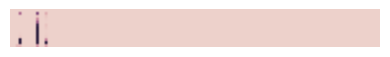

AttributeError: 'AltLuminarCNN' object has no attribute 'conv_layers'

In [19]:
sample = datasets_matched["test"][4]
print(sample["labels"])
features = sample["features"]
print(features.shape)
visualize_features(features.T)
plt.show()
with torch.inference_mode():
    conv = (
        classifier.conv_layers(features.T.unsqueeze(0).to("cuda"))
        .cpu()
        .detach()[0].T
    )
    print(conv.shape)
    visualize_features(conv.clip(0, 1).numpy().T)
    plt.show()

    ff = classifier.projection[:-1](conv.unsqueeze(0).to("cuda")).cpu().detach()[0]
    print(ff.shape)
    visualize_features(ff.numpy().T)
    plt.show()

In [ ]:
sample = datasets_matched["test"][-1]
print(sample["labels"])
features = sample["features"]
print(features.shape)
visualize_features(features.T)
plt.show()

with torch.inference_mode():
    conv = (
        classifier.conv_layers[:-1](features.T.unsqueeze(0).to("cuda"))
        .cpu()
        .detach()[0]
        .T
    )
    print(conv.shape)
    visualize_features(conv.clip(0, 1).numpy().T)
    plt.show()

    ff = classifier.projection[:-1](conv.unsqueeze(0).to("cuda")).cpu().detach()[0]
    print(ff.shape)
    visualize_features(ff.numpy().T)
    plt.show()

In [ ]:
raise RuntimeError()

In [ ]:
import json

print(json.dumps(scores, indent=4))
with open("../logs/luminar/gpt2_first_128-3_epochs.json", "w") as f:
    json.dump(scores, f, indent=4)

In [ ]:
datasets = {}
for subset in [
    "blog_authorship_corpus",
    "student_essays",
    "cnn_news",
    "euro_court_cases",
    "house_of_commons",
    "arxiv_papers",
    "gutenberg_en",
    "en",
    "bundestag",
    "spiegel_articles",
    "gutenberg_de",
    "de",
]:
    datset_config_name = f"{subset}-fulltext"
    datasets[datset_config_name] = load_dataset(
        "liberi-luminaris/PrismAI-encoded-gpt2",
        datset_config_name,
        token=HF_TOKEN,
        split="human+gpt_4o_mini",
    )

In [ ]:
dataset = load_dataset(
    "liberi-luminaris/PrismAI-fulltext", "cnn_news", split="human+gpt_4o_mini"
)
dataset_human = dataset.filter(lambda sample: sample["agent"] == "human")
source_ids = set(
    dataset_human.shuffle(seed=42).take(len(dataset_human) // 10 * 8)["id_source"]
)
dataset_train = dataset.filter(lambda sample: sample["id_source"] in source_ids)

In [ ]:
datasets_truncated = {}
for datset_config_name, dataset in datasets.items():
    datasets_truncated[datset_config_name] = dataset.with_format(
        "numpy", columns=["features"], output_all_columns=True
    ).map(
        lambda batch: {"features": batch["features"][:, :256]},
        batched=True,
    )

In [ ]:
datasets_considered = {
    key: value
    for key, value in datasets_truncated.items()
    if not key.startswith("de-") and not key.startswith("en-")
}

In [ ]:
import pandas as pd

domains = [
    "Web Blogs",
    "Essays",
    "CNN",
    "ECHR",
    "HoC",
    "arXiv",
    "Gutenberg$_{en}$",
    "Bundestag$_{de}$",
    "Spiegel$_{de}$",
    "Gutenberg$_{de}$",
    "All$_{en}$",
    "All$_{de}$",
]
name_map = {
    "blog_authorship_corpus": "Web Blogs",
    "student_essays": "Essays",
    "cnn_news": "CNN",
    "euro_court_cases": "ECHR",
    "house_of_commons": "HoC",
    "arxiv_papers": "arXiv",
    "gutenberg_en": "Gutenberg$_{en}$",
    "bundestag": "Bundestag$_{de}$",
    "spiegel_articles": "Spiegel$_{de}$",
    "gutenberg_de": "Gutenberg$_{de}$",
    "en": "All$_{en}$",
    "de": "All$_{de}$",
}

results = [
    {"domain": name_map[key.split("-", 1)[0]]}
    | {
        "f1": value["f1"],
        "acc": value["accuracy"],
        "auroc": value["auroc"],
    }
    for key, value in scores.items()
]
metric_df = (
    pd.DataFrame(results)
    .set_index("domain")
    .sort_index(key=lambda x: list(map(domains.index, x)))
)
print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

In [ ]:
# def run_detector(
#     detector: DetectorABC, datasets: dict[str, DatasetDict]
# ) -> dict[str, float]:
#     scores = {}
#     for config_name, ds in tqdm(datasets.items(), desc="Predicting on Datasets"):
#         dataset: Dataset = ds["test"].map(
#             detector.tokenize,
#             input_columns=["text"],
#             batched=True,
#             batch_size=1024,
#             desc="Tokenizing",
#         )
#         dataset = dataset.sort("length")
#         dataset = dataset.map(
#             detector.process,
#             batched=True,
#             batch_size=128,
#             desc="Predicting",
#         )

#         dataset_np = dataset.select_columns(["prediction", "label"]).with_format(
#             "numpy"
#         )

#         acc, f1, auroc = get_scores(dataset_np["label"], dataset_np["prediction"])
#         scores[config_name] = {"accuracy": acc, "f1": f1, "auroc": auroc}

#         acc, f1, auroc = get_scores(
#             dataset_np["label"],
#             dataset_np["prediction"],
#             calibrated=True,
#         )
#         scores[config_name] |= {
#             "accuracy_calibrated": acc,
#             "f1_calibrated": f1,
#             "auroc_calibrated": auroc,
#         }
#     return scores


In [ ]:
# def evaluate(model: LuminarClassifier, datasets: dict[str, DatasetDict]) -> dict:
#     scores = {}
#     for config_name, dataset in tqdm(datasets.items(), desc="Evaluating", leave=False):
#         ds = (
#             dataset["test"]
#             .with_format("torch", ["features"])
#             .map(model.process, batched=True, batch_size=32, desc="Predicting")
#         )
#         dataset_np = ds.select_columns(["prediction", "label"]).with_format("numpy")

#         acc, f1, auroc = get_scores(dataset_np["label"], dataset_np["prediction"])
#         scores[config_name] = {
#             "accuracy": acc,
#             "f1": f1,
#             "auroc": auroc,
#         }

#         acc, f1, auroc = get_scores(
#             dataset_np["label"],
#             dataset_np["prediction"],
#             calibrated=True,
#         )
#         scores[config_name] |= {
#             "accuracy_calibrated": acc,
#             "f1_calibrated": f1,
#             "auroc_calibrated": auroc,
#         }

#     return scores